In [2]:
import pandas as pd
import xarray as xr
from windwhisper import WindTurbines, NoisePropagation, NoiseAnalysis, HumanHealth

# we can preload the wind speed data, otherwise, the tool will do it every time
filepath_wind_speed = "/Users/romain/GitHub/windwhisper/dev/fixtures/era5_mean_2013-2022_month_by_hour.nc"
filepath_correction = "/Users/romain/GitHub/windwhisper/dev/fixtures/ratio_gwa2_era5.nc"

def wind_speed_data():
    wind_speed = xr.open_dataset(filepath_wind_speed).to_array().mean(dim="month")
    correction = xr.open_dataset(filepath_correction).to_array()
    correction = correction.sel(variable='ratio_gwa2_era5_mean_WS').interp(latitude=wind_speed.latitude, longitude=wind_speed.longitude, method="linear")
    return wind_speed * correction

data = wind_speed_data()

# note: make ensure latitude and longitude coordinates are sorted in ascending order
elevation_data = xr.open_dataset("/Users/romain/GitHub/windwhisper/dev/fixtures/Copernicus_DSM_90m_COG_EU.nc")

In [3]:
fp_locations = "filtered_coordinates_no_lakes.csv"
locs = pd.read_csv(fp_locations, sep=",")

In [4]:
results = []

In [5]:
%%time
specs = [
    #(45, 40, 500),  # Diameter_m, Hub_height_m, P_rated_kW
    #(55, 70, 1000),
    (90, 100, 2500),
    #(130, 110, 5000),
    #(195, 120, 10000),
]

for i, row in locs.iterrows():

    if i < 43:  # Skip the first 43 rows
        continue

    for spec in specs:
        diameter, hub_height, power = spec
        lat = float(row["Latitude"])
        lon = float(row["Longitude"])
        wind_turbine = {
            i: {
                "diameter": diameter,
                "hub height": hub_height,
                "position": (lat, lon),
                "power": power,
            }
        }
        # Add the wind turbine to the list or process it as needed
        # For example, you could append it to a list or print it
        print(i)
        wt = WindTurbines(
            wind_turbines=wind_turbine,
            wind_speed_data=data,
        )

        noise_prop = NoisePropagation(
            wind_turbines=wt.wind_turbines,
            humidity=70,
            temperature=20,
            elevation_data=elevation_data,
        )

        noise_analysis = NoiseAnalysis(
            noise_propagation=noise_prop,
            wind_turbines=wt.wind_turbines,
        )

        hh = HumanHealth(
            noise_analysis
        )

        results.append(
            {
                "lat": lat,
                "lon": lon,
                "diameter": diameter,
                "hub_height": hub_height,
                "power": power,
                "average wind speed": wt.wind_turbines[i]["mean_wind_speed"].mean().values,
                "average Lden": noise_analysis.merged_map["combined"].mean().values,
                "average load factor": hh.load_factor,
                "production": hh.electricity_production,
                "HH wo turbines (ha)": hh.human_health_wo_turbines["highly_annoyed"].sum().item(),
                "HH wo turbines (sleep disorder)": hh.human_health_wo_turbines["high_sleep_disorder"].sum().item(),
                "HH wo turbines (ischemic heart disease)": hh.human_health_wo_turbines["ischemic_heart_disease"].sum().item(),
                "HH wo turbines (diabetes)": hh.human_health_wo_turbines["diabetes"].sum().item(),
                "HH wo turbines (stroke)": hh.human_health_wo_turbines["stroke"].sum().item(),
                "HH with turbines (ha)": hh.human_health["highly_annoyed"].sum().item(),
                "HH with turbines (sleep disorder)": hh.human_health["high_sleep_disorder"].sum().item(),
                "HH with turbines (ischemic heart disease)": hh.human_health["ischemic_heart_disease"].sum().item(),
                "HH with turbines (diabetes)": hh.human_health["diabetes"].sum().item(),
                "HH with turbines (stroke)": hh.human_health["stroke"].sum().item(),
                "HH wo turbines (sum)": sum(
                    da.sum().item() for da in hh.human_health_wo_turbines.data_vars.values()
                ),
                "HH with turbines (sum)": sum(
                    da.sum().item() for da in hh.human_health.data_vars.values()
                ),
            }
        )

43
Using local elevation data
44
Using local elevation data
45
Using local elevation data
46
Using local elevation data
47
Using local elevation data
48
Using local elevation data
49
Using local elevation data
50
Using local elevation data
51
Using local elevation data
52
Using local elevation data
53
Using local elevation data
54
Using local elevation data
55
Using local elevation data
56
Using local elevation data
57
Using local elevation data
58
Using local elevation data
59
Using local elevation data
60
Using local elevation data
61
Using local elevation data
62
Using local elevation data
63
Using local elevation data
64
Using local elevation data
65
Using local elevation data
66
Using local elevation data
67
Using local elevation data
68
Using local elevation data
69
Using local elevation data
70
Using local elevation data
71
Using local elevation data
72
Using local elevation data
73
Using local elevation data
74
Using local elevation data
75
Using local elevation data
76
Using l

In [7]:
results

[]

In [7]:
df = pd.DataFrame(results)
df.to_excel("switzerland_human_health2.xlsx", index=False)

In [14]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, MultiPolygon
from windwhisper import DATA_DIR

# === User-defined inputs ===
coordinates_csv = "grid_Switzerland_GPS.csv"  # Path to your CSV file
shapefile_folder = DATA_DIR / "ne_110m_admin_0_countries"  # Folder containing .shp file
shapefile_name = "ne_110m_admin_0_countries.shp"  # Main shapefile name
target_country = "Switzerland"  # Country to filter by

# === Step 1: Load coordinates ===
df = pd.read_csv(coordinates_csv)
df[['Latitude', 'Longitude']] = df['Latitude;Longitude'].str.split(';', expand=True)
df['Latitude'] = pd.to_numeric(df['Latitude'])
df['Longitude'] = pd.to_numeric(df['Longitude'])

# === Step 2: Convert to GeoDataFrame ===
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# === Step 3: Load your own country borders shapefile ===
shapefile_path = f"{shapefile_folder}/{shapefile_name}"
world = gpd.read_file(shapefile_path)

# === Step 4: Filter for Switzerland ===
if 'ADMIN' in world.columns:
    switzerland = world[world['ADMIN'] == target_country]
elif 'name' in world.columns:
    switzerland = world[world['name'] == target_country]
else:
    raise ValueError("Cannot find 'ADMIN' or 'name' column in shapefile attributes.")

# === Step 5: Apply spatial filter ===
swiss_geom = switzerland.geometry.values[0]
if isinstance(swiss_geom, MultiPolygon):
    mask = gdf.geometry.apply(lambda point: any(point.within(poly) for poly in swiss_geom.geoms))
else:
    mask = gdf.geometry.within(swiss_geom)

# === Step 6: Filter and export ===
gdf_filtered = gdf[mask].drop(columns=['geometry', 'Latitude;Longitude'])
gdf_filtered.to_csv("filtered_coordinates_in_Switzerland.csv", index=False)

print("Filtered coordinates saved to 'filtered_coordinates_in_Switzerland.csv'")


Filtered coordinates saved to 'filtered_coordinates_in_Switzerland.csv'


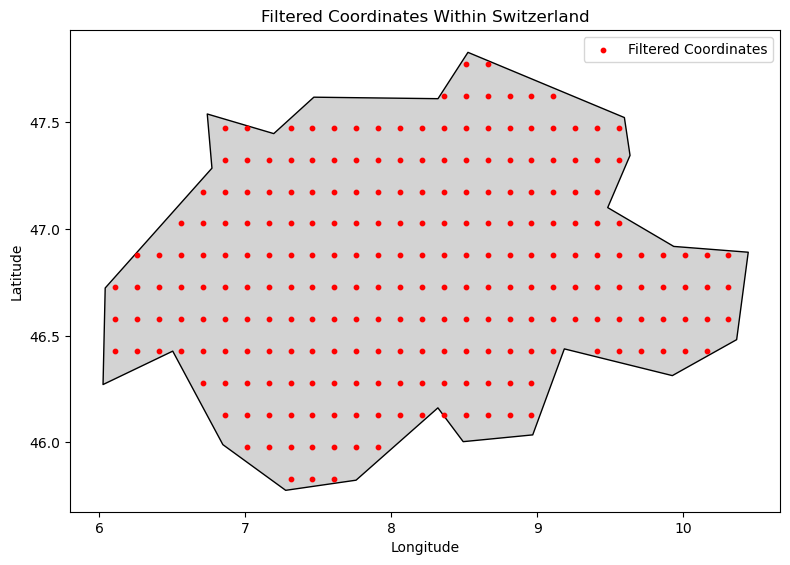

In [15]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# === User inputs ===
filtered_csv = "filtered_coordinates_in_Switzerland.csv"
shapefile_folder = DATA_DIR / "ne_110m_admin_0_countries"
shapefile_name = "ne_110m_admin_0_countries.shp"
target_country = "Switzerland"

# === Step 1: Load filtered coordinates ===
df = pd.read_csv(filtered_csv)
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf_points = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# === Step 2: Load Switzerland boundary ===
world = gpd.read_file(f"{shapefile_folder}/{shapefile_name}")

# Try matching on 'ADMIN' or 'name' column
if 'ADMIN' in world.columns:
    switzerland = world[world['ADMIN'] == target_country]
elif 'name' in world.columns:
    switzerland = world[world['name'] == target_country]
else:
    raise ValueError("Could not find country name column in shapefile.")

# === Step 3: Plot ===
fig, ax = plt.subplots(figsize=(8, 10))
switzerland.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf_points.plot(ax=ax, markersize=10, color='red', label='Filtered Coordinates')

ax.set_title("Filtered Coordinates Within Switzerland")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

plt.tight_layout()
plt.show()


In [17]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, MultiPolygon

# === User-defined inputs ===
filtered_csv = "filtered_coordinates_in_Switzerland.csv"
shapefile_folder = DATA_DIR / "ne_110m_admin_0_countries"
shapefile_name = "ne_110m_admin_0_countries.shp"
target_country = "Switzerland"

# === Step 1: Load filtered coordinates ===
df = pd.read_csv(filtered_csv)
unique_lats = np.unique(df['Latitude'])
unique_lons = np.unique(df['Longitude'])

# === Step 2: Create interpolated grid (densify by 2x)
dense_lats = np.round(np.linspace(unique_lats.min(), unique_lats.max(), len(unique_lats)*2 - 1), 8)
dense_lons = np.round(np.linspace(unique_lons.min(), unique_lons.max(), len(unique_lons)*2 - 1), 8)

# Meshgrid and flatten
dense_grid = pd.DataFrame([(lat, lon) for lat in dense_lats for lon in dense_lons], columns=['Latitude', 'Longitude'])

# === Step 3: Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(dense_grid['Longitude'], dense_grid['Latitude'])]
gdf = gpd.GeoDataFrame(dense_grid, geometry=geometry, crs="EPSG:4326")

# === Step 4: Load Switzerland boundary
world = gpd.read_file(f"{shapefile_folder}/{shapefile_name}")
if 'ADMIN' in world.columns:
    switzerland = world[world['ADMIN'] == target_country]
elif 'name' in world.columns:
    switzerland = world[world['name'] == target_country]
else:
    raise ValueError("Could not find country name column.")

swiss_geom = switzerland.geometry.values[0]
if isinstance(swiss_geom, MultiPolygon):
    mask = gdf.geometry.apply(lambda point: any(point.within(poly) for poly in swiss_geom.geoms))
else:
    mask = gdf.geometry.within(swiss_geom)

# === Step 5: Save densified points
gdf_filtered = gdf[mask].drop(columns='geometry')
gdf_filtered.to_csv("filtered_coordinates_densified_x2.csv", index=False)

print(f"Densified grid saved with {len(gdf_filtered)} points to 'filtered_coordinates_densified_x2.csv'")


Densified grid saved with 954 points to 'filtered_coordinates_densified_x2.csv'


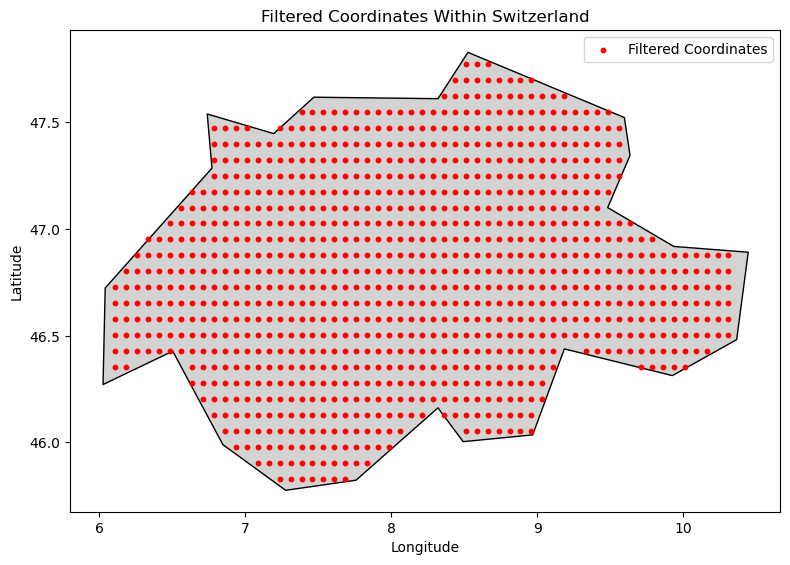

In [18]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# === User inputs ===
filtered_csv = "filtered_coordinates_densified_x2.csv"
shapefile_folder = DATA_DIR / "ne_110m_admin_0_countries"
shapefile_name = "ne_110m_admin_0_countries.shp"
target_country = "Switzerland"

# === Step 1: Load filtered coordinates ===
df = pd.read_csv(filtered_csv)
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf_points = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# === Step 2: Load Switzerland boundary ===
world = gpd.read_file(f"{shapefile_folder}/{shapefile_name}")

# Try matching on 'ADMIN' or 'name' column
if 'ADMIN' in world.columns:
    switzerland = world[world['ADMIN'] == target_country]
elif 'name' in world.columns:
    switzerland = world[world['name'] == target_country]
else:
    raise ValueError("Could not find country name column in shapefile.")

# === Step 3: Plot ===
fig, ax = plt.subplots(figsize=(8, 10))
switzerland.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf_points.plot(ax=ax, markersize=10, color='red', label='Filtered Coordinates')

ax.set_title("Filtered Coordinates Within Switzerland")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

plt.tight_layout()
plt.show()


In [27]:
import geopandas as gpd
from shapely.geometry import MultiPolygon

# === Load densified grid ===
gdf = gpd.read_file("filtered_coordinates_densified_x2.csv")
gdf['geometry'] = gpd.points_from_xy(gdf['Longitude'], gdf['Latitude'])
gdf = gpd.GeoDataFrame(gdf, geometry='geometry', crs="EPSG:4326")

# === Load lakes shapefile ===
# Example: Natural Earth 10m lakes
lakes = gpd.read_file("switzerland-latest-free.shp/gis_osm_water_a_free_1.shp")  # Change this to your actual lake data path


# Assign CRS if missing (Natural Earth = EPSG:4326)
if lakes.crs is None:
    lakes.set_crs("EPSG:4326", inplace=True)

# Optional: restrict to Swiss bounding box for performance
lakes = lakes.to_crs("EPSG:4326")
swiss_bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
lakes = lakes.cx[swiss_bounds[0]:swiss_bounds[2], swiss_bounds[1]:swiss_bounds[3]]

# === Remove points that fall within any lake ===
lake_geom = lakes.unary_union  # merge into one MultiPolygon
if isinstance(lake_geom, MultiPolygon):
    lake_mask = gdf.geometry.apply(lambda pt: any(pt.within(poly) for poly in lake_geom.geoms))
else:
    lake_mask = gdf.geometry.within(lake_geom)

gdf_no_lakes = gdf[~lake_mask]

# === Save result ===
gdf_no_lakes.drop(columns="geometry").to_csv("filtered_coordinates_no_lakes.csv", index=False)
print(f"Saved {len(gdf_no_lakes)} points (lakes removed) to 'filtered_coordinates_no_lakes.csv'")


/var/folders/cn/pys1j9rn0y7djkhv3hfdtrs00000gn/T/ipykernel_41261/634100859.py:24: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  lake_geom = lakes.unary_union  # merge into one MultiPolygon


Saved 907 points (lakes removed) to 'filtered_coordinates_no_lakes.csv'


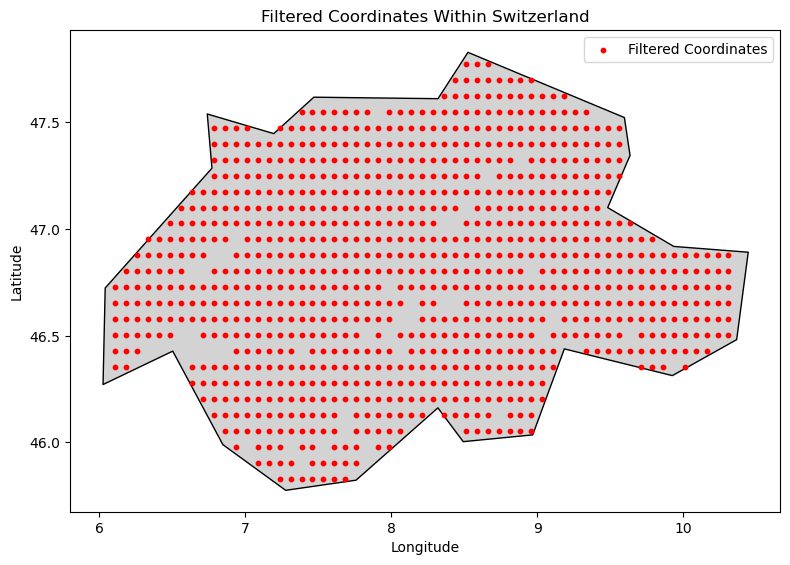

In [28]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# === User inputs ===
filtered_csv = "filtered_coordinates_no_lakes.csv"
shapefile_folder = DATA_DIR / "ne_110m_admin_0_countries"
shapefile_name = "ne_110m_admin_0_countries.shp"
target_country = "Switzerland"

# === Step 1: Load filtered coordinates ===
df = pd.read_csv(filtered_csv)
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf_points = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# === Step 2: Load Switzerland boundary ===
world = gpd.read_file(f"{shapefile_folder}/{shapefile_name}")

# Try matching on 'ADMIN' or 'name' column
if 'ADMIN' in world.columns:
    switzerland = world[world['ADMIN'] == target_country]
elif 'name' in world.columns:
    switzerland = world[world['name'] == target_country]
else:
    raise ValueError("Could not find country name column in shapefile.")

# === Step 3: Plot ===
fig, ax = plt.subplots(figsize=(8, 10))
switzerland.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf_points.plot(ax=ax, markersize=10, color='red', label='Filtered Coordinates')

ax.set_title("Filtered Coordinates Within Switzerland")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

plt.tight_layout()
plt.show()


In [26]:
print(lakes)

                                              geometry
535  POLYGON ((6.8712 46.45872, 6.91653 46.44194, 6...
542  POLYGON ((9.71858 47.54669, 9.73212 47.53845, ...
607  POLYGON ((9.06598 47.72301, 9.10366 47.70064, ...
666  POLYGON ((8.84609 46.16907, 8.84785 46.1673, 8...


In [3]:
fp_locations = "Wind_Turbines_CH.csv"
locs = pd.read_csv(fp_locations, sep=",")

In [4]:
results = []

In [5]:
%%time


for i, row in locs.iterrows():

    lat = float(row["Latitude"])
    lon = float(row["Longitude"])
    hub_height = float(row["Hub_height_m"])
    power = float(row["P_rated_kW"])
    diameter = float(row["Diameter_m"])

    wind_turbine = {
        i: {
            "diameter": diameter,
            "hub height": hub_height,
            "position": (lat, lon),
            "power": power,
        }
    }
    # Add the wind turbine to the list or process it as needed
    # For example, you could append it to a list or print it
    print(i)
    wt = WindTurbines(
        wind_turbines=wind_turbine,
        wind_speed_data=data,
    )

    noise_prop = NoisePropagation(
        wind_turbines=wt.wind_turbines,
        humidity=70,
        temperature=20,
        elevation_data=elevation_data,
    )

    noise_analysis = NoiseAnalysis(
        noise_propagation=noise_prop,
        wind_turbines=wt.wind_turbines,
    )

    hh = HumanHealth(
        noise_analysis
    )

    results.append(
        {
            "lat": lat,
            "lon": lon,
            "diameter": diameter,
            "hub_height": hub_height,
            "power": power,
            "average wind speed": wt.wind_turbines[i]["mean_wind_speed"].mean().values,
            "average Lden": noise_analysis.merged_map["combined"].mean().values,
            "average load factor": hh.load_factor,
            "production": hh.electricity_production,
            "HH wo turbines (ha)": hh.human_health_wo_turbines["highly_annoyed"].sum().item(),
            "HH wo turbines (sleep disorder)": hh.human_health_wo_turbines["high_sleep_disorder"].sum().item(),
            "HH wo turbines (ischemic heart disease)": hh.human_health_wo_turbines["ischemic_heart_disease"].sum().item(),
            "HH wo turbines (diabetes)": hh.human_health_wo_turbines["diabetes"].sum().item(),
            "HH wo turbines (stroke)": hh.human_health_wo_turbines["stroke"].sum().item(),
            "HH with turbines (ha)": hh.human_health["highly_annoyed"].sum().item(),
            "HH with turbines (sleep disorder)": hh.human_health["high_sleep_disorder"].sum().item(),
            "HH with turbines (ischemic heart disease)": hh.human_health["ischemic_heart_disease"].sum().item(),
            "HH with turbines (diabetes)": hh.human_health["diabetes"].sum().item(),
            "HH with turbines (stroke)": hh.human_health["stroke"].sum().item(),
            "HH wo turbines (sum)": sum(
                da.sum().item() for da in hh.human_health_wo_turbines.data_vars.values()
            ),
            "HH with turbines (sum)": sum(
                da.sum().item() for da in hh.human_health.data_vars.values()
            ),
        }
    )

0
Using local elevation data
1
Using local elevation data
2
Using local elevation data
3
Using local elevation data
4
Using local elevation data
5
Using local elevation data
6
Using local elevation data
7
Using local elevation data
8
Using local elevation data
9
Using local elevation data
10
Using local elevation data
11
Using local elevation data
12
Using local elevation data
13
Using local elevation data
14
Using local elevation data
15
Using local elevation data
16
Using local elevation data
17
Using local elevation data
18
Using local elevation data
19
Using local elevation data
20
Using local elevation data
21
Using local elevation data
22
Using local elevation data
23
Using local elevation data
24
Using local elevation data
25
Using local elevation data
26
Using local elevation data
27
Using local elevation data
28
Using local elevation data
29
Using local elevation data
30
Using local elevation data
31
Using local elevation data
32
Using local elevation data
33
Using local eleva

In [6]:
df = pd.DataFrame(results)
df.to_excel("human_health_impacts_swiss_turbines.xlsx", index=False)